# CMIP6 Regional variable change

**Following steps are included in this script:**

1. Load netCDF files
2. Compute regional variable change
3. Plot change in reional parallel coordinate plots

## Import Packages

In [1]:
# ========== Packages ==========
import glob
import os
import xarray as xr
import pandas as pd
import multiprocessing as mp
import copy
import numpy as np
import regionmask
import math
import cftime
#import load_and_preprocess as lap 
from matplotlib.colors import Normalize

# For plotting
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, textcomp}'

# For color map
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

In [2]:
#Check all possible fonts
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# Set the font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]

## Functions

### 2. Subdivide Regions, Compute Mean and Change

#### Main functions

In [ ]:
def subdivide_region_and_compute_mean(ds_dict):
    
    ds_dict_regions = {}
    
    for scenario_name, scenario_dict in ds_dict.items():
        ds_dict_regions[scenario_name] = apply_region_mask(scenario_dict, with_global=True)
        ds_dict_regions[scenario_name] = calculate_spatial_mean( ds_dict_regions[scenario_name])
   
    return ds_dict_regions

In [ ]:
def compute_change_dict(ds_dict):
    """
    Create a new dictionary that saves the changes of the scenarios to the historical period
    for each model.

    Parameters:
    - ds_dict: Dictionary containing datasets for all scenarios and models, structured as ds_dict[scenario][model].

    Returns:
    - A dictionary with keys formatted as 'historical-<scenario>' for each scenario change
      and each key containing a model-wise dictionary of changes.
    """
    ds_dict_change = {}
    scenarios = list(ds_dict.keys())
    historical = scenarios[0]  # Assuming the first scenario is always 'historical'

    # Iterate through scenarios (skipping the first 'historical' scenario)
    for scenario in scenarios[1:]:
        change_key = f'historical-{scenario}'
        ds_dict_change[change_key] = {}

        ds_base = ds_dict[historical]
        ds_future = ds_dict[scenario]
        ds_change = compute_change(ds_base, ds_future)

        # Drop 'member_id' if present
        if 'member_id' in ds_change:
            ds_change = ds_change.drop('member_id')

        ds_dict_change[change_key] = ds_change
    
    return ds_dict_change

#### Apply region mask

In [ ]:
def apply_region_mask(ds_dict, with_global=False):
    """
    Applies the AR6 land region mask to datasets in the provided dictionary, adds a region dimension,
    and optionally includes a 'Global' aggregation.

    Args:
        ds_dict (dict): A dictionary of xarray datasets.
        with_global (bool): If True, includes a 'Global' region with aggregated data.

    Returns:
        dict: A new dictionary where keys are the same as in the input dictionary,
              and each value is an xarray Dataset with a region dimension added to each variable,
              and optionally includes a 'Global' region.
    """

    land_regions = regionmask.defined_regions.ar6.land
    
    if with_global:
        global_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    
    ds_masked_dict = {}

    for ds_name, ds in ds_dict.items():
        ds_masked = xr.Dataset()  # Initiate an empty Dataset for the masked data
        
        # Get attributes
        attrs = ds.attrs
        
        for var in ds:
            # Get the binary mask
            mask = land_regions.mask_3D(ds[var])
            
            var_attrs = ds[var].attrs

            # Multiply the original data with the mask to get the masked data
            masked_var = ds[var] * mask

            # Replace 0s with NaNs, if desired
            masked_var = masked_var.where(masked_var != 0)

            if with_global:
                # Convert the global mask to 3D to match the regional mask dimensions
                glob_mask = global_mask.mask_3D(ds[var])
                
                global_masked_var = ds[var] * glob_mask
                
                # Replace 0s with NaNs, if desired
                global_masked_var = global_masked_var.where(global_masked_var != 0)

                # Combine masked data
                masked_var = xr.concat([masked_var, global_masked_var], dim='region')
                
            # Add the masked variable to the output Dataset
            ds_masked[var] = masked_var

            ds_masked[var].attrs = var_attrs

        # Copy dataset attributes
        ds_masked.attrs.update(ds.attrs)
        
        correct_region_numbers = np.arange(0, ds_masked.dims['region'])

        ds_masked = ds_masked.assign_coords(region=correct_region_numbers)

        # Add the modified dataset to the dictionary
        ds_masked_dict[ds_name] = ds_masked

    return ds_masked_dict

#### Calculate spatial mean

In [ ]:
def calculate_spatial_mean(ds_dict):
    ds_dict_mean = {}
    
    for key, ds in ds_dict.items():
        attrs = ds.attrs
        
        # Initialize a new Dataset for this key
        ds_dict_mean[key] = xr.Dataset()
        
        for var in list(ds.data_vars.keys()):
            var_attrs = ds[var].attrs
            
            ds_dict_mean[key][var] = ds[var].mean(['lon', 'lat'])
            ds_dict_mean[key][var].attrs = var_attrs
        
        ds_dict_mean[key].attrs = attrs
        
    return ds_dict_mean

#### Compute Change

In [ ]:
def is_numeric(data):
    try:
        _ = data.astype(float)
        return True
    except (ValueError, TypeError):
        return False

def compute_change(ds_dict_hist, ds_dict_fut, var_rel_change=None):
    ds_dict_change = {}

    for name, ds_hist in ds_dict_hist.items():
        if name in ds_dict_fut:
            ds_future = ds_dict_fut[name]
            common_vars = set(ds_hist.data_vars).intersection(ds_future.data_vars)

            ds_change = ds_hist.copy(deep=True)
            
            if var_rel_change == 'all':
                var_rel_change = common_vars
                
            for var in common_vars:
                if is_numeric(ds_hist[var].data) and is_numeric(ds_future[var].data):
                    # Always compute percentage change for 'mrso' as models have different depths
                    if var == 'mrso':
                        rel_change = (ds_future[var] - ds_hist[var]) / ds_hist[var].where(ds_hist[var] != 0) * 100
                        ds_change[var].data = rel_change.data
                        ds_change[var].attrs['units'] = '%'
                    elif var_rel_change is not None and var in var_rel_change:
                        # Compute relative change where ds_hist is not zero for specified variables
                        rel_change = (ds_future[var] - ds_hist[var]) / ds_hist[var].where(ds_hist[var] != 0) * 100
                        ds_change[var].data = rel_change.data
                        ds_change[var].attrs['units'] = '%'
                    else:
                        # Compute absolute change for other variables
                        abs_change = ds_future[var] - ds_hist[var]
                        ds_change[var].data = abs_change.data

            ds_change.attrs = ds_future.attrs
            ds_dict_change[name] = ds_change

    return ds_dict_change

### 3. Plot Variable Change

#### Main plotting function

In [ ]:
def plot_region_change(ds_dict_change, selected_indices, selected_vars=None, common_scale_for_mm_day=True, legend=True, save_fig=False, subdiv=False):
    # Load Colormap
    bgws_cm, norm = create_bgws_cm()
    
    # Compute Ensemble statisitc
    ds_dict_change = compute_ensemble(ds_dict_change, 'mean')
    ds_dict_change = compute_ensemble(ds_dict_change, 'median')
    
    # Get all model names
    models = list(ds_dict_change.keys())
    
    # Get data info
    variables, display_variables, experiment_id, description, months, yearly_sum, change_type, region_names = extract_variables(ds_dict_change, selected_vars)
    
    # Define regions to plot
    selected_indices = ds_dict_change['Ensemble mean'].region.values.tolist() if selected_indices == "ALL" else selected_indices
    
    # Loop over regions to create single plot for each region
    for region_idx in selected_indices:
        
        if subdiv:
            for subdiv_idx in range(ds_dict_change['Ensemble mean'].dims['subdivision']):
                print(subdiv_idx)
                # Create figure and axes
                fig, axes = plt.subplots(1, len(variables), sharey=False, figsize=(20, 12))

                # Create regional plot
                plot_region(fig, axes, models, region_idx, ds_dict_change, variables, display_variables, change_type, bgws_cm, subdiv_idx, use_common_scale_for_mm_day=common_scale_for_mm_day) 

                # Add legend and colorbar
                if legend:
                    add_legend_and_colorbar(fig, axes, models, norm, bgws_cm, description, region_names, region_idx)

                plt.show()

                if save_fig:
                    save_figure(fig, change_type, experiment_id, months, yearly_sum, region_names, region_idx, subdiv_idx, legend=legend, common_scale_for_mm_day=common_scale_for_mm_day)
                else:
                    print('Figure not saved. If you want to save the figure add save_fig=True to the function call')

        else:
             # Create figure and axes
            fig, axes = plt.subplots(1, len(variables), sharey=False, figsize=(20, 12))

            # Create regional plot
            plot_region(fig, axes, models, region_idx, ds_dict_change, variables, display_variables, change_type, bgws_cm, use_common_scale_for_mm_day=common_scale_for_mm_day) 

            # Add legend and colorbar
            if legend:
                add_legend_and_colorbar(fig, axes, models, norm, bgws_cm, description, region_names, region_idx)

            plt.show()

            if save_fig:
                save_figure(fig, change_type, experiment_id, months, yearly_sum, region_names, region_idx, legend=legend, common_scale_for_mm_day=common_scale_for_mm_day)
            else:
                print('Figure not saved. If you want to save the figure add save_fig=True to the function call')
                

#### Create Colormap

In [ ]:
def create_bgws_cm():
    # Define start and end colors for both gradients
    deep_blue = (20/255, 110/255, 180/255)
    light_blue = (180/255, 215/255, 255/255)
    deep_green = (14/255, 119/255, 14/255)
    light_green = (160/255, 220/255, 140/255)

    # Create custom colormaps
    blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", [light_blue, deep_blue], N=4)
    green_cmap = LinearSegmentedColormap.from_list("green_cmap", [deep_green, light_green], N=4)

    # Sample colors from colormaps
    blue_colors = [blue_cmap(i) for i in np.linspace(0, 1, 4)]
    green_colors = [green_cmap(i) for i in np.linspace(0, 1, 4)]

    # Combine both gradients
    combined_grad = green_colors + blue_colors

    # Define boundaries
    boundaries = sorted([-0.1, -0.075, -0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1])
    norm = BoundaryNorm(boundaries, len(combined_grad), clip=True)

    cmap_name = 'BGWS colormap'
    bgws_cm = LinearSegmentedColormap.from_list(cmap_name, combined_grad, N=len(combined_grad))

    # Return the colormap and norm
    return bgws_cm, norm

#### Get Data Info for Plot

In [ ]:
def determine_change_type(ds_dict):
    """
    Determines the type of change (relative or absolute) based on the units of the first 
    variable found in the provided dataset dictionary.
    
    Parameters:
    - ds_dict: A dictionary structured as ds_dict[scenario][model] containing xarray Dataset or DataArray objects.
    
    Returns:
    - A string indicating the type of change: 'rel_change' for relative change (units in '%'), 
      otherwise 'abs_change' for absolute change.
    """
    # Attempt to retrieve the first dataset from the dictionary
    try:
        first_scenario = list(ds_dict.keys())[0]
        first_model = list(ds_dict[first_scenario].keys())[0]
        first_dataset = ds_dict[first_scenario][first_model]
        
        # Depending on the structure, handle both Dataset and DataArray cases
        if isinstance(first_dataset, xr.Dataset):
            # For Dataset, find the first data variable
            first_var_name = list(first_dataset.data_vars)[0]
            units = first_dataset[first_var_name].attrs.get('units', '')
        elif isinstance(first_dataset, xr.DataArray):
            # For DataArray, directly access its units attribute
            units = first_dataset.attrs.get('units', '')
        else:
            raise ValueError("Unexpected data structure. Expected xarray Dataset or DataArray.")
        
        # Determine change type based on units
        return 'rel_change' if units == '%' else 'abs_change'
    except Exception as e:
        print(f"Error determining change type: {e}")
        return 'abs_change'  # Default to 'abs_change' in case of error or unexpected data structure

def prepare_display_variables(variables):
    var_map = {
        'tas': ('T', '°C'),
        'vpd': ('VPD', 'hPa'),
        'gpp': ('GPP', r'\frac{\frac{gC}{m^2}}{day}'),  
        'pr': ('P', r'\frac{mm}{day}'),
        'mrro': ('R', r'\frac{mm}{day}'),
        'evspsbl': ('ET', r'\frac{mm}{day}'),
        'tran': ('Tran', r'\frac{mm}{day}'),
        'evapo': ('E', r'\frac{mm}{day}'),
        'lai': ('Lai', r'\frac{m^2}{m^2}'),
        'mrso': ('SM', '\%'),
        'rgtr': ('P/T', r'\frac{GPP}{T}'),
        'et_partitioning': ('EP', r'\frac{E-Tran}{ET}'),
        'growing_season_length_period': ('GSL', 'months'),
        'RX5day': ('RX5d', 'mm'),
        'growing_season_length_winter': ('GSL', 'months'),
        'growing_season_length_summer': ('GSL', 'months'),
        'growing_season_length_fall': ('GSL', 'months'),
        'growing_season_length_spring': ('GSL', 'months'),
        'wue': ('WUE', r'\frac{GPP}{Tran}'),
        'bgws': ('BGWS', r'\frac{R-T}{P}')
    }
    display_variables = {}
    for var in variables:
        if var in var_map:
            abbreviation, units = var_map[var]
            # Enclose units in \left[ and \right] for automatic sizing
            display_variables[var] = f"${{\Delta\, \mathrm{{\it{{{abbreviation}}}}}}}$ \n $\\left[{units}\\right]$"
        else:
            print(f"Variable '{var}' not found in var_map.")
            display_variables[var] = var  # Or handle this case as appropriate
    return display_variables


def extract_variables(ds_dict, selected_vars):
    ensemble = ds_dict['Ensemble mean']
    variables = [var for var in ensemble.data_vars.keys() if var not in ['bgws', 'region', 'abbrevs', 'names', 'member_id']] if selected_vars is None else [var for var in selected_vars if var in ensemble.data_vars.keys()]
    experiment_id = ds_dict[list(ds_dict.keys())[0]].experiment_id
    description = ds_dict[list(ds_dict.keys())[0]].description
    months = ds_dict[list(ds_dict.keys())[0]].months
    yearly_sum = ds_dict[list(ds_dict.keys())[0]].yearly_sum
    display_variables = prepare_display_variables(variables)
    change_type = determine_change_type(ds_dict)
    region_names = ds_dict[list(ds_dict.keys())[0]].names
    return variables, display_variables, experiment_id, description, months, yearly_sum, change_type, region_names

#### Compute ensemble

In [ ]:
def compute_ensemble(ds_dict_change, statistic):
    
    # Drop previously computed ensemble statistics
    for key in [f'Ensemble {statistic}']:
        if key in ds_dict_change:
            ds_dict_change.pop(key)
    
    # Get attrs of the variables
    var_attrs = {}
    for var in ds_dict_change[list(ds_dict_change.keys())[0]].data_vars:
        var_attrs[var] = ds_dict_change[list(ds_dict_change.keys())[0]][var].attrs
            
    
    # Coompute ensemble mean
    combined = xr.concat(ds_dict_change.values(), dim='ensemble')
    ds_dict_change[f'Ensemble {statistic}'] = getattr(combined, statistic)(dim='ensemble')
    
    
    # Add variable attrs
    for var in ds_dict_change[f'Ensemble {statistic}'].data_vars:
        ds_dict_change[f'Ensemble {statistic}'][var].attrs = var_attrs[var] 
        
    ssp = ds_dict_change[list(ds_dict_change.keys())[0]].experiment_id
    
    # Add ensemble attr
    ds_dict_change[f'Ensemble {statistic}'].attrs = {'experiment_id': f'{ssp}-historical',
                                                    'source_id': f'Ensemble {statistic}',
                                                    'months': 'whole_year',
                                                    'yearly_sum': 'monthly_mean',
                                                    }
            
    return ds_dict_change

#### Legend and colorbar

In [ ]:
def add_legend_and_colorbar(fig, ax, models, norm, bgws_cm, description, region_names, selected_region):
    # Caption and figure saving
    region_name = region_names.isel(region=selected_region).item()
    caption = region_name
    fig.text(0.6, 0.93, caption, ha='center', va='top', fontsize=22, wrap=True)
    
    # Layout adjustments
    #plt.subplots_adjust(wspace=1, hspace=0.7)
    
    # Upper Legend (Ensemble mean, median, and line styles)
    upper_legend_position = [0.975, 0.61, 0.1, 0.125]  # Adjust position as needed
    upper_legend_ax = fig.add_axes(upper_legend_position, frame_on=False)
    upper_legend_elements = [
        plt.Line2D([0], [0], marker='D', markeredgecolor='red', markerfacecolor='none', label='Ensemble mean', markersize=10, linestyle='None', lw=2),
        plt.Line2D([0], [0], marker='o', mec='orange', mfc='none', label='Ensemble median', markersize=14, linestyle='None', mew=2),
        plt.Line2D([0], [0], color='black', label='+ $\Delta$ BGWS', linestyle='-', linewidth=2),
        plt.Line2D([0], [0], color='black', label='- $\Delta$ BGWS', linestyle='--', linewidth=2)  
    ]
    upper_legend = upper_legend_ax.legend(handles=upper_legend_elements, fontsize=18, loc='center', ncol=2,
                                          columnspacing=1, handletextpad=0.5, borderaxespad=0.5)
    upper_legend_ax.axis('off')
    upper_legend.get_frame().set_facecolor('none')
    upper_legend.get_frame().set_edgecolor('none')
    
    # Define starting position and spacing for the model name annotations
    start_x = 0.92  # Right side of the figure; adjust as needed
    start_y = 0.597  # Starting height; adjust as needed
    spacing_y = 0.0315  # Vertical spacing between model names; adjust as needed
    num_columns = 2  # Number of columns for model names
    column_width = 0.117  # Horizontal space between columns

    # Filter out the ensemble mean and median for the model names annotation
    model_names = [model for model in models if model not in ["Ensemble mean", "Ensemble median"]]

    # Calculate how many names per column
    names_per_column = len(model_names) // num_columns + (len(model_names) % num_columns > 0)

    # Loop through the model names to place them as text annotations
    for idx, model_name in enumerate(model_names):
        column = idx // names_per_column
        row = idx % names_per_column
        x_position = start_x + column * column_width  # Adjust x based on column
        y_position = start_y - row * spacing_y  # Adjust y based on row

        # Place text annotation
        fig.text(x_position, y_position, f"{idx + 1}: {model_name}", fontsize=18, transform=fig.transFigure, ha='left', va='top')
 
    # Add the colorbar below the lower legend
    colorbar_position = [0.92, 0.3, 0.2, 0.03]  # right, up, length, width
    cbar_ax = fig.add_axes(colorbar_position)
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=bgws_cm), cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label("$\Delta$ Blue-Green Water Share", fontsize=18, weight='bold')
    cbar.set_ticks([-0.1, -0.075, -0.05, -0.025, 0, 0.025, 0.05, 0.075, 0.1])
    cbar.set_ticklabels(["-10", "", "-5", "", "0", "", "5", "", "10"])
    cbar.ax.tick_params(labelsize=14)

#### Plot regions

In [ ]:
def round_based_on_position(x):
    if x == 0:
        return 0
    abs_x = abs(x)
    if abs_x >= 10:
        # For numbers >= 10, round up to the next integer
        return math.ceil(x)
    elif abs_x >= 1:
        # For numbers < 10 and >= 1, round up to the nearest 0.5 or the next integer
        return max(1.5, math.ceil(x * 2) / 2)
    else:
        # For numbers < 1, round up in a way that increases the first significant digit
        digit_pos = -int(math.floor(math.log10(abs_x)))  # Position of first significant digit
        increment = 10 ** (-digit_pos)
        return math.ceil(x / increment) * increment

def adjust_array(arr):
    abs_max_val = np.max(np.abs(arr))
    new_max = round_based_on_position(abs_max_val)
    
    # The adjustment logic above ensures we're rounding up correctly
    # Construct the new array with the calculated new maximum
    new_arr = np.array([-new_max, -new_max / 2, 0, new_max / 2, new_max])
    return new_arr

In [ ]:
def plot_region(fig, axes, models, selected_region, ds_dict_change, variables, display_variables, change_type, bgws_cm, use_common_scale_for_mm_day=True):
    # Iterate over models and variables to plot
    for i, model_name in enumerate(models, start=1):
        ds = ds_dict_change[model_name]  # Get the dataset for the current model
        prev_xy = None

        for j, variable in enumerate(variables):
            if variable in ds.data_vars:
                selected_data = ds[variable].sel(region=selected_region).values.item()  # Get the single value for the selected region
                        
                bgws_value = ds['bgws'].sel(region=selected_region).values.item()  # Get bgws value for linestyle decision

                # Normalize bgws value for color mapping
                color = bgws_cm((bgws_value - -0.1) / (0.1 - -0.1))

                current_xy = (j, value)
                #print(model_name, variable, value)
                
                if np.isnan(value):
                    prev_xy = None
                    continue

                if model_name.lower() == "ensemble mean":
                    axes[j].plot(j, value, 'D', mec='red', mfc='none', markersize=22, mew=2, zorder=5)
                elif model_name.lower() == "ensemble median":
                    axes[j].plot(j, value, 'o', mec='orange', mfc='none', markersize=28, mew=2, zorder=4)
                else:
                    if j % 2 == 0:
                        dot_color = '#f0f0f0'
                    else: 
                        dot_color = 'white'
                    axes[j].plot(j, value, 'o', color=dot_color, markersize=38, zorder=1)
                    axes[j].annotate(str(i), xy=current_xy, xytext=(0, 0), textcoords='offset points',
                                     fontsize=38, weight='bold', color=color,
                                     ha='center', va='center', zorder=2)

                if prev_xy is not None:
                    linestyle = '--' if bgws_value < 0 else '-'
                    con = ConnectionPatch(xyA=prev_xy, xyB=current_xy, coordsA="data", coordsB="data",
                                          axesA=axes[j-1], axesB=axes[j],
                                          linestyle=linestyle, shrinkA=17, shrinkB=17, color=color, linewidth=2)  
                    fig.add_artist(con)

                prev_xy = current_xy
            else:
                prev_xy = None
    
    
     # Identify "mm/day" variables
    mm_day_variables = ['pr', 'mrro', 'evspsbl', 'tran', 'evapo'] 

    if use_common_scale_for_mm_day:
        # Calculate the max absolute value for "mm/day" variables across all models
        max_abs_mm_day = 0
        for var in mm_day_variables:
            for model_name, ds in ds_dict_change.items():
                if var in ds.data_vars:
                    abs_values = np.abs(ds[var].sel(region=selected_region).values)
                    max_abs_mm_day = max(max_abs_mm_day, np.nanmax(abs_values))
        common_ylim = max_abs_mm_day * 1.05  # Common y-axis limit for "mm/day" variables, scaled up slightly for visual margin
    else:
        common_ylim = None  # This will signify not to use a common y-limit for "mm/day" variables

    # Calculate maximum absolute value for each variable across all models for the selected region
    max_abs_values = {}
    for var in variables:
        if var not in mm_day_variables or not use_common_scale_for_mm_day:
            max_values = []
            for model_name, ds in ds_dict_change.items():
                if var in ds.data_vars:
                    value = abs(ds[var].sel(region=selected_region).values.item())
                    if np.isnan(value):
                        continue
                    max_values.append(value)
            max_abs_values[var] = max(max_values) if max_values else 0
        else:
            # Use common y-axis limit for "mm/day" variables if flag is set
            max_abs_values[var] = common_ylim

    # Adjust axes properties and add variable names
    for j, var in enumerate(variables):
        # Set x-axis ticks and labels with improved formatting
        axes[j].set_xlim(j - 1, j + 1)
        axes[j].set_xticks([j])
        axes[j].spines['top'].set_visible(False)
        axes[j].spines['bottom'].set_visible(False)
        axes[j].spines['right'].set_visible(False)
        axes[j].set_xticklabels([display_variables[var]], fontdict={'size': 25})
       
        axes[j].tick_params(axis='x', length=10, color='white')#,  labelrotation=90)   # Adjust x-axis tick label size
            
        # Add horizontal line at y=0
        axes[j].axhline(y=0, color='gray', linestyle='-', linewidth=1)  

        # Set y-axis ticks and labels with improved formatting
        # Calculate the maximum absolute value for the variable
        max_abs_value = max_abs_values[var] * 1.05
        ticks = adjust_array(np.linspace(-max_abs_value, max_abs_value, num=5))
        #print(max_abs_value, ticks)
        # Set the y-axis limits to ensure 0 is always in the middle
        axes[j].set_ylim(ticks[0], ticks[-1])
        axes[j].set_yticks(ticks)
        axes[j].spines['left'].set_bounds(ticks[0], ticks[-1]) # Set bounds for left spine
        axes[j].tick_params(axis='y', labelsize=18)  # Adjust y-axis tick label size
        
        # Coloring every second subplot's background
        if j % 2 == 0:  # This checks if the index is odd, applying the color to every second subplot
            axes[j].set_facecolor('#f0f0f0')  # Light gray background
    
        if j == 0:
            # This is the first subplot, so add a y-axis label here
            axes[j].set_ylabel("End-of-century response", fontsize=25)
    
        # Improved tick label formatting to remove unnecessary trailing zeros
        if j > 0:  # Check if not the first axis
            axes[j].set_yticklabels([f'{tick:.2f}'.rstrip('0').rstrip('.') if '.' in f'{tick:.2f}' and tick != 0 else '' for tick in ticks])
            ticks = axes[j].yaxis.get_major_ticks() 
            # Modify properties of the first tick
            tick_to_modify = 2  # Index of the tick to modify
            ticks[tick_to_modify].tick1line.set_markersize(50)
            ticks[tick_to_modify].tick1line.set_markeredgecolor('gray')
            ticks[tick_to_modify].tick1line.set_markeredgewidth(1)

        else:
            axes[j].set_yticklabels([f'{tick:.2f}'.rstrip('0').rstrip('.') if '.' in f'{tick:.2f}' else f'{tick:.2f}' for tick in ticks])

#### Save figures

In [ ]:
def save_figure(fig, change, experiment_id, months, yearly_sum, region_names, region_idx, subdiv_idx, legend, common_scale_for_mm_day):
    # Caption and figure saving
    region_name = (region_names.isel(region=region_idx).item()).replace("/", "_")
    savepath = os.path.join('../..', 'results', 'CMIP6', period, 'time', 'mean', 'regional_var_change', region_name)
    os.makedirs(savepath, exist_ok=True)

    if legend:
        if common_scale_for_mm_day:
            filename = f'{region_name}_{subdiv_idx}_regional_var_{change}_{experiment_id}_{months}_{yearly_sum}.pdf'
        else:
            filename = f'{region_name}_{subdiv_idx}_regional_var_{change}_{experiment_id}_{months}_{yearly_sum}_no_common_y_scale.pdf' 
    else:
        if common_scale_for_mm_day:
            filename = f'{region_name}_{subdiv_idx}_regional_var_{change}_{experiment_id}_{months}_{yearly_sum}_without_legend.pdf' 

        else:
            filename = f'{region_name}_{subdiv_idx}_regional_var_{change}_{experiment_id}_{months}_{yearly_sum}_without_legend_no_common_y_scale.pdf' 
    filepath = os.path.join(savepath, filename)
    fig.savefig(filepath, dpi=600, bbox_inches='tight', format='pdf')
    print(f'Figure saved under {filepath}')

## 1. Load and Preprocess

In [ ]:
#Restore the load and preprocess function

#This is what it need to do:
season=None # None, 'spring', summer, fall, winter
ds_dict = lap.load_and_preprocess(vars='all', scenarios=['historical', 'ssp370'], models='all', period=season, yearly_sum=False, period_statistic='mean')

In [1]:
import sys
import os

In [4]:
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), '../../../../common/src'))
import data_handling.load_preprocessed_data as lpd

In [ ]:
# Initialize dictionaries for preprocessed datasets
ds_dict = {}

In [5]:
# Source models (IDs)
source_ids = ['BCC-CSM2-MR']

In [6]:
experiment_ids = ['historical']

In [ ]:
# Loop through each scenario
for scenario in experiment_ids:
    print(scenario)

In [6]:
ds_dict_temp = {}
ds_dict[scenario] = {}

In [7]:
def categorize_variables(vars_selected, period):
    # Define categories based on temporal resolution
    monthly_variables = ['tas', 'pr', 'vpd', 'mrro', 'mrso', 'tran', 'lai', 'gpp', 'evspsbl', 'evapo']
    yearly_variables = ['RX5day']
    
    # Adjust the handling of period
    if period is not None:
        period_variables = [f'growing_season_length_{period}']  # Use the specific period if provided
        yearly = period  # The default yearly category name
    else:
        period_variables = ['growing_season_length_period']  # Use a general name if no specific period is provided
        yearly = 'year'  # The default yearly category name
        period = 'period'  # Use 'period' as the category name if no specific period is provided
    
    # Initialize categories
    categories = {
        'month': [],
        yearly: [],
        period: []
    }

    # Check the selection and categorize
    if vars_selected == 'all':
        categories['month'].extend(monthly_variables)
        categories[yearly].extend(yearly_variables)
        categories[period].extend(period_variables)
    else:
        for var in vars_selected:
            if var in monthly_variables:
                categories['month'].append(var)
            elif var in yearly_variables:
                categories[yearly].append(var)
            elif var == 'growing_season_length':  # Use a general check for the variable name
                categories[period].append(var if period is None else f'growing_season_length_{period}')
            else:
                print(f"Warning: Variable '{var}' not recognized.")
                
    return categories

In [8]:
# Categorize variables based on temporal resolution
categorized_variables = categorize_variables('all', period=None)

In [ ]:
def load_data(scenario, models, data_state, temporal_resolution, variables):
    # Initialize the dictionary to store datasets
    ds_dict = {}

    
                ds = open_and_merge_datasets(folder, model, experiment_id, temp_res, variables)
                ds_dict[experiment_id][model] = ds
            except ValueError as e:
                print(f"Failed to load data for model {model} in scenario {experiment_id}: {e}")

    return ds_dict

In [12]:
import xarray as xr

## load_preprocessed_data.py

In [57]:
# Import necessary libaries

import xarray as xr
import os
import copy
import numpy as np
import multiprocessing as mp

In [118]:
# Set input

"""
data_product = e.g. CMIP6 ERA5 CMIP5 CORDEX
experiment = e.g. historical ssp370 
temp_res = e.g. day month year
var = e.g. pr lai tas
"""
BASE_DIR = '/work/ch0636/g300115/phd_project/common/data/processed'
data_product = 'CMIP6'
experiment = 'historical'
experiments = ['historical', 'ssp370']
temp_res = 'month' # 'period' 'year'
season_name = 'spring'
if temp_res == 'season':
    temp_res = f'season/{season_name}'
variables = ['pr']#, 'tas']#['pr', 'lai']
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0'] #CESM2-WACCM CNRM-ESM2-1 GISS-E2-1-G MIROC-ES2L NorESM2-MM UKESM1-0-LL CanESM5 CNRM-CM6-1 GFDL-ESM4 IPSL-CM6A-LR MPI-ESM1-2-LR TaiESM1
model = 'BCC-CSM2-MR'

In [6]:
def open_dataset(filepath):
    """
    Open dataset based on input filepath.

    Parameters:
    - filepath: Path to file with filename.

    Returns:
    - A dataset with loaded file.
    """
    ds = xr.open_dataset(filepath)
    return ds

In [30]:
def open_models_variables(BASE_DIR, data_product, experiment, temp_res, model, variables):
    """
    Open dataset of one model for different variables and merge them to one common xarray dataset.

    Parameters:
    - data_product: e.g. CMIP6 ERA5 CMIP5 CORDEX
    - experiment: e.g. historical ssp370 
    - temp_res: e.g. day month season year period
    - model: e.g. CAMS-CSM1-0 CESM2-WACCM CNRM-ESM2-1 GISS-E2-1-G MIROC-ES2L NorESM2-MM
    - variables: List of different variables e.g. [pr, lai, tas]

    Returns:
    - A dataset with all variables of one model loaded in one xarray dataset.
    """
    filepaths = []
    for var in variables:
        file = f'{data_product}/{experiment}/{temp_res}/{var}/{model}.nc'
        file_path = os.path.join(BASE_DIR, file)
        if file_path:
            filepaths.append(file_path)
        else:
            print(f"No file found for variable '{var}' in model '{model}'.")
            print(fp)

    datasets = [xr.open_dataset(fp) for fp in filepaths]
    ds = xr.merge(datasets)
    return ds

In [51]:
# Test open_models_variables
ds = open_models_variables(BASE_DIR, data_product, experiment, temp_res, model, variables)
ds

<xarray.Dataset>
Dimensions:                       (lat: 149, lon: 360, time: 30)
Coordinates:
  * lat                           (lat) int64 -59 -58 -57 -56 ... 86 87 88 89
  * lon                           (lon) int64 -180 -179 -178 ... 177 178 179
  * time                          (time) object 1985-03-01 00:00:00 ... 2014-...
Data variables:
    growing_season_length_spring  (lat, lon) float64 ...
    RX5day                        (time, lat, lon) float32 ...
Attributes: (12/69)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            2289.0
    comment:                          The model integration starts from the p...
    ...                               ...
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.BCC-CSM2-MR.historical.Lmon.gn
    log:                              Unit of mrso converted from kg/m² to mm...
    regrid_method:                    conservative
    months:                           whole_year
    yearly_sum:                       monthly_mean

In [46]:
def load_multiple_models_and_experiments(BASE_DIR, data_product, experiments, temp_res, models, variables):
    """
    Open datasets for mutiple models and experiments in one xarray dictionary.

    Parameters:
    - BASE_DIR: Path to base directory to pass it to open function.
    - data_product: Data product e.g. CMIP6 to pass it to open function.
    - experiments: List of experiments to load e.g. historical ssp370.
    - temp_res: e.g. day month season year period
    - models: List of models to load.
    - variables: List of variables to load.
    

    Returns:
    - A xarray dictionary containig the models with all vairables for each experiment respectively.
    """

    # Initialize the dictionary to store datasets
    ds_dict = {}

    # Loop over each experiment and model name to load and merge datasets
    for experiment in experiments:
        ds_dict[experiment] = {}
        for model_name in models:
            try:
                ds = open_models_variables(BASE_DIR, data_product, experiment, temp_res, model_name, variables)
                ds_dict[experiment][model_name] = ds
            except ValueError as e:
                print(f"Failed to load data for model {model_name} in scenario {experiment}: {e}")

    return ds_dict

In [139]:
# Test load_multiple_models
ds_dict = load_multiple_models_and_experiments(BASE_DIR, data_product, experiments, temp_res, models, variables)
print(ds_dict.keys())
ds_dict[list(ds_dict.keys())[0]].keys()

dict_keys(['historical', 'ssp370'])


dict_keys(['BCC-CSM2-MR', 'CAMS-CSM1-0'])

In [180]:
ds_dict[list(ds_dict.keys())[1]]['BCC-CSM2-MR'].pr

<xarray.DataArray 'pr' (time: 1032, lat: 160, lon: 320)>
[52838400 values with dtype=float32]
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    original_name:  PRECT
    cell_methods:   area: time: mean (interval: 5 minutes)
    cell_measures:  area: areacella
    units:          kg/m²/s

In [135]:
# Constants
SEASONS_TO_MONTHS = {
    'nh_winter': [12, 1, 2],
    'nh_spring': [3, 4, 5],
    'nh_summer': [6, 7, 8],
    'nh_fall': [9, 10, 11]
}

MONTH_NAMES = {
    1: 'J', 2: 'F', 3: 'M', 4: 'A', 5: 'M', 6: 'J',
    7: 'J', 8: 'A', 9: 'S', 10: 'O', 11: 'N', 12: 'D'
}

def get_time_selection_months(time_selection):
    """
    Determine the months and time selection name based on the provided time selection.

    Parameters:
    - time_selection: Selection of time spans within the dataset.

    Returns:
    - Tuple containing a list of months and a time selection name.
    """
    months = []
    time_selection_name = 'whole_year'
    
    if time_selection is None:
        months = list(range(1, 13))  # All months
    elif isinstance(time_selection, int):
        time_selection_name = MONTH_NAMES[time_selection]
        months = [time_selection]
    elif isinstance(time_selection, str):
        if 'and' in time_selection:
            seasons = time_selection.lower().split('and')
            time_selection_name = ''
            for season in seasons:
                season = season.strip()
                months.extend(SEASONS_TO_MONTHS.get(season, []))
                time_selection_name += ''.join(MONTH_NAMES[m] for m in SEASONS_TO_MONTHS.get(season, []))
        else:
            months = SEASONS_TO_MONTHS.get(time_selection.lower(), [])
            time_selection_name = ''.join(MONTH_NAMES[m] for m in months)
    elif isinstance(time_selection, list):
        time_selection_name = ''.join(MONTH_NAMES[m] for m in time_selection if m in MONTH_NAMES)
        months = time_selection
    else:
        raise ValueError("time_selection must be None, an integer, a string representing a single season, "
                         "a string with multiple seasons separated by 'and', or a list of integers.")
    return months, time_selection_name

def select_time_period(ds, start_year, end_year):
    """
    Select the data within the specified time period.

    Parameters:
    - ds: The dataset to select from.
    - start_year: The start year of the period.
    - end_year: The end year of the period.

    Returns:
    - The dataset containing data only within the specified time period.
    """
    if start_year and end_year:
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-31'
        ds = ds.sel(time=slice(start_date, end_date))
    return ds

def select_months(ds, months):
    """
    Filter the data to include only the specified months.

    Parameters:
    - ds: The dataset to filter.
    - months: List of months to include.

    Returns:
    - The filtered dataset.
    """
    if months:
        month_mask = ds['time.month'].isin(months)
        ds = ds.where(month_mask, drop=True)
    return ds

def select_period(ds_dict, start_year=None, end_year=None, specific_months_or_seasons=None):
    """
    Select period and optionally compute yearly sums.

    Parameters:
    - ds_dict: Dictionary with xarray datasets.
    - start_year: The start year of the period.
    - end_year: The end year of the period.
    - specific_months_or_seasons (int, list, str, None): Single month (int), list of months (list), multiple seasons (str) to select,
                                             or None to not select any specific month or season.

    Returns:
    - A dictionary containing copies of the original datasets with data only for the selected time selection.
    """
    # Create a deep copy of the original ds_dict to avoid modifying it directly
    ds_dict_copy = copy.deepcopy(ds_dict)

    # Get the months and time_selection name based on the provided time_selection
    months, time_selection_name = get_time_selection_months(specific_months_or_seasons)

    for key, ds in ds_dict_copy.items():
        # Select the time period
        ds = select_time_period(ds, start_year, end_year)
        
        # Select the months
        ds = select_months(ds, months)

        # Store the original attributes of each variable
        original_attrs = {var: ds[var].attrs for var in ds.data_vars}

        # Reassign the original attributes back to each variable
        for var in ds.data_vars:
            ds[var].attrs = original_attrs[var]

        ds_dict_copy[key] = ds
        ds_dict_copy[key].attrs['months'] = time_selection_name

    return ds_dict_copy

In [171]:
# Test select period for one experiment only
ds_dict_period = {}
for experiment in experiments:
    ds_dict_period[experiment] = select_period(ds_dict[experiment], start_year=1985 
            if experiment == 'historical' else 2071, end_year=2014 if experiment == 'historical' else 2100, specific_months_or_seasons=None)

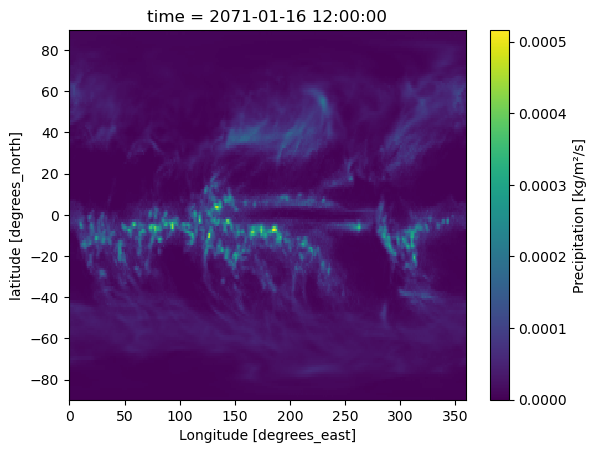

In [172]:
ds_dict_period[experiment]['BCC-CSM2-MR'].pr.isel(time=0).plot()

In [162]:
# Test compute period mean
ds_dict_period_mean = {}
for experiment in experiments:
    ds_dict_period_mean[experiment] = compute_temporal_or_spatial_statistic(ds_dict_period[experiment], dimension='temporal', statistic='mean')

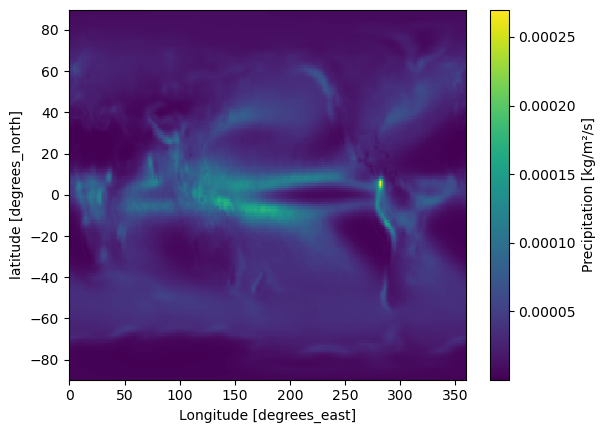

In [166]:
ds_dict_period_mean[experiment]['BCC-CSM2-MR'].pr.plot()

# process_data.py

In [132]:
import xarray as xr
import numpy as np
import multiprocessing as mp

In [147]:
def compute_yearly_sum(ds):
    """
    Compute the yearly sum while ignoring NaN values.

    Parameters:
    - ds: The dataset to compute the yearly sum from.

    Returns:
    - The dataset with yearly summed values, preserving NaN values for grid cells that were NaN in the original data.
    """
    if 'time' in ds.dims and 'time' in ds.coords:
        attrs = ds.attrs
        days = ds['time'].dt.days_in_month
        
        # Check if the unit is in 'day' or 'month' and replace it with 'year'
        for var in ds.data_vars:
            unit = ds[var].attrs.get('units', '')
            if 'day' in unit or 'month' in unit:
                new_unit = unit.replace('day', 'year').replace('month', 'year')
                ds[var].attrs['units'] = new_unit
            else:
                print(f"No yearly sum computed as variable '{var}' has units '{unit}'")
                return ds

        # Calculate the yearly sum, ignoring NaN values
        yearly_sum_ds = (ds * days).resample(time='AS').sum(dim='time', skipna=True)
        
        # Create a mask for NaN values in the original dataset
        nan_mask = ds.isnull().any(dim='time')
        
        # Apply the mask to the resulting dataset to preserve NaN values
        yearly_sum_ds = yearly_sum_ds.where(~nan_mask)
        
        yearly_sum_ds.attrs = attrs
        
        return yearly_sum_ds
    return ds

In [158]:
def compute_statistic_per_model(ds, dimension, statistic):
    """
    Computes a specified statistic for a single xarray dataset.

    Parameters:
    - ds: xarray Dataset to compute the statistic on.
    - dimension: The dimension to compute over, e.g., 'temporal' or 'spatial'.
    - statistic: The statistic to compute, e.g., 'mean', 'std', 'min', 'var', 'median'.

    Returns:
    - xarray Dataset with the computed statistic.
    """
    if dimension == "temporal":
        return compute_temporal_statistic(ds, statistic)
    elif dimension == "spatial":
        return compute_spatial_statistic(ds, statistic)
    else:
        raise ValueError(f"Invalid dimension '{dimension}' specified.")

def compute_temporal_statistic(ds, statistic):
    """
    Compute statistic over the temporal dimension.

    Parameters:
    - ds: xarray Dataset to compute the statistic on.
    - statistic: The statistic to compute, e.g., 'mean', 'std', 'min', 'var', 'median'.

    Returns:
    - xarray Dataset with the computed statistic over the temporal dimension.
    """
    # Compute the statistic
    stat_ds = getattr(ds, statistic)("time", keep_attrs=True, skipna=True)
    
    # Create an attribute called period to log the start and end year of the computed temporal statistic
    stat_ds.attrs['period'] = [str(ds.time.dt.year[0].values), str(ds.time.dt.year[-1].values)]
    return stat_ds


def compute_spatial_statistic(ds, statistic):
    """
    Compute statistic over spatial dimension.

    Parameters:
    - ds: xarray Dataset to compute the statistic on.
    - statistic: The statistic to compute, e.g., 'mean', 'std', 'min', 'var', 'median'.

    Returns:
    - xarray Dataset with the computed statistic over spatial dimension.
    """
    # Calculate weights based on latitude
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    # Log the weights for debugging and documentation purposes
    ds.attrs['weights'] = weights.values.tolist()
    
    # Apply weighted spatial averaging
    ds_weighted = ds.weighted(weights)
    
    # Compute the statistic on the weighted dataset
    stat_ds = getattr(ds_weighted, statistic)(("lon", "lat"), keep_attrs=True, skipna=True)
    
    return stat_ds

In [161]:
def compute_temporal_or_spatial_statistic(ds_dict, dimension, statistic):
    """
    Computes the specified statistic for each dataset in the dictionary.

    Parameters:
    - ds_dict: Dictionary of xarray datasets.
    - dimension: The dimension to compute over, e.g., 'temporal' or 'spatial'.
    - statistic: The statistic to compute, e.g., 'mean', 'std', 'min', 'max', 'var', 'median'.

    Returns:
    - Dictionary with computed statistic for each dataset.
    """
    # Check if function inputs are valid
    validate_inputs(ds_dict, dimension, statistic)

    # Compute statistic for each model using parallel processing
    with mp.Pool() as pool:
        results = pool.starmap(compute_statistic_per_model, [(ds, dimension, statistic) for ds in ds_dict.values()])

    return dict(zip(ds_dict.keys(), results))

def validate_inputs(ds_dict, dimension, statistic):
    if not isinstance(ds_dict, dict):
        raise TypeError("ds_dict must be a dictionary of xarray datasets.")
    if not all(isinstance(ds, xr.Dataset) for ds in ds_dict.values()):
        raise TypeError("All values in ds_dict must be xarray datasets.")
    if statistic not in ["mean", "std", "min", "max", "var", "median"]:
        raise ValueError(f"Invalid statistic '{statistic}' specified.")
    if dimension not in ["temporal", "spatial"]:
        raise ValueError(f"Invalid dimension '{dimension}' specified.")

In [ ]:
season=None # None, 'spring', summer, fall, winter
ds_dict = lap.load_and_preprocess(vars='all', scenarios=['historical', 'ssp370'], models='all', period=season, yearly_sum=False, period_statistic='mean')

## 2. Subdivide Regions, Compute Mean and Change

In [ ]:
#ds_dict_regions = lap.subdivide_region_and_compute_mean(ds_dict, with_global=True, spatial_mean=False) #Only compute spatial mean here if you want to assess a single period

In [ ]:
ds_dict_change = lap.compute_change_dict(ds_dict)

In [ ]:
ds_dict_change['ssp370-historical'] = lap.compute_bgws(ds_dict_change['ssp370-historical'])

In [ ]:
ds_dict_change_regions_mean = lap.subdivide_region_and_compute_mean(ds_dict_change, with_global=True, spatial_mean=True) 

In [ ]:
ds_dict_change_regions_mean['ssp370-historical'] = compute_ensemble(ds_dict_change_regions_mean['ssp370-historical'], 'mean')
ds_dict_change_regions_mean['ssp370-historical'] = compute_ensemble(ds_dict_change_regions_mean['ssp370-historical'], 'median')

### 3. Compute Subdivisions and Mean

In [ ]:
def expand_with_subdivisions(ds_current, ds_change, variable='bgws'):
    # Masks for current dataset
    mask_bgws_positive = ds_current[variable] > 0
    mask_bgws_negative = ds_current[variable] < 0

    # Masks for change dataset
    mask_change_positive = ds_change[variable] > 0
    mask_change_negative = ds_change[variable] < 0

    # Create the subdivision masks
    subdivisions_masks = xr.DataArray(
        np.array([
            mask_bgws_positive & mask_change_negative,
            mask_bgws_positive & mask_change_positive,
            mask_bgws_negative & mask_change_negative,
            mask_bgws_negative & mask_change_positive
        ]),
        dims=['subdivision', 'lat', 'lon', 'region'],
        coords={
            'subdivision': [0, 1, 2, 3],
            'lat': ds_current.lat,
            'lon': ds_current.lon,
            'region': ds_current.region
        }
    )

    # Expand datasets by broadcasting with subdivision masks
    def expand_dataset(ds):
        expanded_vars = {}
        for name, var in ds.data_vars.items():
            # Use the .where() method to mask the data based on the subdivision mask
            expanded_var = var.expand_dims({'subdivision': subdivisions_masks['subdivision'].sizes['subdivision']}).where(subdivisions_masks)
            expanded_vars[name] = expanded_var
        
        # Create new dataset with expanded variables
        expanded_ds = xr.Dataset(expanded_vars, coords={**ds.coords, 'subdivision': subdivisions_masks['subdivision']})
        return expanded_ds

    ds_change_expanded = expand_dataset(ds_change)
    
    ds_change_expanded.attrs = ds_change.attrs

    return ds_change_expanded

In [ ]:
ds_dict_regions_change_subdiv = {}

for model, ds in ds_dict_regions_change[list(ds_dict_regions_change.keys())[0]].items():
    ds_dict_regions_change_subdiv[model] = expand_with_subdivisions(ds_dict_regions['historical'][model], ds, variable='bgws')

In [ ]:
import xarray as xr
import numpy as np

# Initialize a dictionary to hold the mean datasets for each model
ds_dict_regional_mean_change_subdiv = {}

# Assuming 'ds_dict_regions_change_subdiv' contains your datasets indexed by model names
for model, ds in ds_dict_regions_change_subdiv.items():
    # Retrieve the total number of regions and subdivisions
    num_regions = len(ds.coords['region'])
    num_subdivisions = len(ds.coords['subdivision'])
    
    # Prepare dimensions and coordinates for the new dataset
    new_coords = {
        'region': ds.coords['region'],
        'subdivision': ds.coords['subdivision'],
        'abbrevs': ('region', ds.coords['abbrevs'].values),
        'names': ('region', ds.coords['names'].values)
    }
    
    # Create a dictionary to store variables with (region, subdivision) dimensions
    data_vars = {}

    # Loop through each data variable
    for var in ds.data_vars:
        mean_values = xr.DataArray(
            data=np.zeros((num_regions, num_subdivisions)),
            dims=['region', 'subdivision'],
            coords=new_coords
        )

        # Loop through each region and subdivision
        for region_idx in range(num_regions):
            for subdiv_idx in range(num_subdivisions):
                # Select data for the current region and subdivision
                selected_data = ds[var].isel(region=region_idx, subdivision=subdiv_idx)
                
                # Compute mean across 'lat' and 'lon' dimensions only
                mean_value = selected_data.mean(dim=['lat', 'lon'], skipna=True)
                
                # Assign the computed mean value to the correct position in the DataArray
                mean_values[region_idx, subdiv_idx] = mean_value
                
        # Copy the attributes from the original variable
        mean_values.attrs = ds[var].attrs

        # Add the populated DataArray to the data_vars dictionary
        data_vars[var] = mean_values

    # Create the new dataset with all the variables and coordinates
    new_ds = xr.Dataset(data_vars, coords=new_coords)

    # Copy all attributes from the original dataset
    new_ds.attrs = ds.attrs

    # Store the new dataset in the main dictionary
    ds_dict_regional_mean_change_subdiv[model] = new_ds

# After this loop, ds_dict_regional_mean_change_subdiv will have all the models with their new datasets.

In [ ]:
ds_dict_regions_change_subdiv['BCC-CSM2-MR'].growing_season_length_period

In [ ]:
ds_dict_regions_change_subdiv['BCC-CSM2-MR'].bgws.isel(subdivision=0, region=0).plot()

## 3. Plot regional var change

In [ ]:
if season == None:
    selected_variables = ['tas', 'vpd', 'RX5day', 'pr', 'mrro', 'tran', 'evapo', 
                          'evspsbl', 'mrso', 'lai', 'gpp', 'wue', 
                          'growing_season_length_period', 'bgws']
elif season == 'winter':
    selected_variables = ['tas', 'vpd', 'RX5day', 'pr', 'mrro', 'tran', 'evapo', 
                          'evspsbl', 'mrso', 'lai', 'gpp', 'wue', 
                          'growing_season_length_winter', 'bgws']
elif season == 'spring':
    selected_variables = ['tas', 'vpd', 'RX5day', 'pr', 'mrro', 'tran', 'evapo', 
                          'evspsbl', 'mrso', 'lai', 'gpp', 'wue', 
                          'growing_season_length_spring', 'bgws']
elif season == 'summer':
    selected_variables = ['tas', 'vpd', 'RX5day', 'pr', 'mrro', 'tran', 'evapo', 
                          'evspsbl', 'mrso', 'lai', 'gpp', 'wue', 
                          'growing_season_length_summer', 'bgws']
else:
    selected_variables = ['tas', 'vpd', 'RX5day', 'pr', 'mrro', 'tran', 'evapo', 
                          'evspsbl', 'mrso', 'lai', 'gpp', 'wue', 
                          'growing_season_length_fall', 'bgws']
print(selected_variables)

In [ ]:
def plot_region_change(ddict_change_regions_mean, selected_indices, selected_vars=None, common_scale_for_mm_day=True, legend=True, save_fig=False, subdiv=False):
    # Load Colormap
    bgws_cm, norm = create_bgws_cm()
    
    # Get all model names
    models = list(ds_dict_change.keys())
    
    # Get data info
    variables, display_variables, experiment_id, description, months, yearly_sum, change_type, region_names = extract_variables(ddict_change_regions_mean, selected_vars)
    
    # Define regions to plot
    selected_indices = ddict_change_regions_mean['Ensemble mean'].region.values.tolist() if selected_indices == "ALL" else selected_indices
    
    # Loop over regions to create single plot for each region
    for region_idx in selected_indices:
        
        if subdiv:
            for subdiv_idx in range(ddict_change_regions_mean['Ensemble mean'].dims['subdivision']):
                # Create figure and axes
                fig, axes = plt.subplots(1, len(variables), sharey=False, figsize=(20, 12))

                # Create regional plot
                plot_region_subd(fig, axes, models, region_idx, ddict_change_regions_mean, variables, display_variables, change_type, bgws_cm, subdiv_idx, use_common_scale_for_mm_day=common_scale_for_mm_day) 

                # Add legend and colorbar
                if legend:
                    add_legend_and_colorbar(fig, axes, models, norm, bgws_cm, description, region_names, region_idx)

                plt.show()

                if save_fig:
                    save_figure(fig, change_type, experiment_id, months, yearly_sum, region_names, region_idx, subdiv_idx, legend=legend, common_scale_for_mm_day=common_scale_for_mm_day)
                else:
                    print('Figure not saved. If you want to save the figure add save_fig=True to the function call')

        else:
             # Create figure and axes
            fig, axes = plt.subplots(1, len(variables), sharey=False, figsize=(20, 12))

            # Create regional plot
            plot_region(fig, axes, models, region_idx, ddict_change_regions_mean, variables, display_variables, change_type, bgws_cm, use_common_scale_for_mm_day=common_scale_for_mm_day) 

            # Add legend and colorbar
            if legend:
                add_legend_and_colorbar(fig, axes, models, norm, bgws_cm, description, region_names, region_idx)

            plt.show()

            if save_fig:
                save_figure(fig, change_type, experiment_id, months, yearly_sum, region_names, region_idx, legend=legend, common_scale_for_mm_day=common_scale_for_mm_day)
            else:
                print('Figure not saved. If you want to save the figure add save_fig=True to the function call')

In [ ]:
def plot_region(fig, axes, models, selected_region, ddict_change_regions_mean, variables, display_variables, change_type, bgws_cm, use_common_scale_for_mm_day=True):
    # Fetch region and subdivision names for the title
    region_name = ddict_change_regions_mean[list(ddict_change_regions_mean.keys())[0]].coords['names'].sel(region=selected_region).item()

    # Set the overall title for the plot
    plot_title = f"{region_name}"
    fig.suptitle(plot_title, fontsize=32)

    # Identify "mm/day" variables
    mm_day_variables = ['pr', 'mrro', 'evspsbl', 'tran', 'evapo'] 

    # Calculate global max and min values for each variable across all subdivisions
    global_max_min_values = {}
    global_mm_max = -np.inf
    global_mm_min = np.inf

    for var in variables:
        global_max = -np.inf
        global_min = np.inf
        for model_name, ds in ddict_change_regions_mean.items():
            if var in ds.data_vars:
                selected_data = ds[var].sel(region=selected_region)
                if selected_data.size == 1:
                    value = selected_data.values.item()
                    if not np.isnan(value):
                        if var in mm_day_variables:
                            global_mm_max = max(global_mm_max, np.abs(value))
                            global_mm_min = min(global_mm_min, -np.abs(value))
                        global_max = max(global_max, value)
                        global_min = min(global_min, value)
                else:
                    print(f"Skipping region {selected_region} for model {model_name} and variable {var} due to multiple values or NaNs")
                    continue
        global_max_min_values[var] = (global_min, global_max)

    # Adjust axes properties and add variable names
    for j, var in enumerate(variables):
        if var in mm_day_variables and use_common_scale_for_mm_day:
            max_abs_value = max(abs(global_mm_min), abs(global_mm_max)) * 1.05
        else:
            max_abs_value = max(abs(global_max_min_values[var][0]), abs(global_max_min_values[var][1])) * 1.05

        if np.isnan(max_abs_value):
            continue
        
        # Calculate ticks
        ticks = adjust_array(np.linspace(-max_abs_value, max_abs_value, num=5))
        
        # Set the y-axis limits to ensure 0 is always in the middle
        axes[j].set_ylim(ticks[0], ticks[-1])
        axes[j].set_yticks(ticks)
        axes[j].spines['left'].set_bounds(ticks[0], ticks[-1]) # Set bounds for left spine
        axes[j].tick_params(axis='y', labelsize=18)  # Adjust y-axis tick label size

        # Set x-axis ticks and labels with improved formatting
        axes[j].set_xlim(j - 1, j + 1)
        axes[j].set_xticks([j])
        axes[j].spines['top'].set_visible(False)
        axes[j].spines['bottom'].set_visible(False)
        axes[j].spines['right'].set_visible(False)
        axes[j].set_xticklabels([display_variables[var]], fontdict={'size': 25})
        axes[j].tick_params(axis='x', length=10, color='white')  # Adjust x-axis tick label size
        
        # Add horizontal line at y=0
        axes[j].axhline(y=0, color='gray', linestyle='-', linewidth=1)  

        # Coloring every second subplot's background
        if j % 2 == 0:  # This checks if the index is odd, applying the color to every second subplot
            axes[j].set_facecolor('#f0f0f0')  # Light gray background

        if j == 0:
            # This is the first subplot, so add a y-axis label here
            axes[j].set_ylabel("End-of-century response", fontsize=25)
    
        # Improved tick label formatting to remove unnecessary trailing zeros
        if j > 0:  # Check if not the first axis
            axes[j].set_yticklabels([f'{tick:.2f}'.rstrip('0').rstrip('.') if '.' in f'{tick:.2f}' and tick != 0 else '' for tick in ticks])
            ticks = axes[j].yaxis.get_major_ticks() 
            # Modify properties of the first tick
            tick_to_modify = 2  # Index of the tick to modify
            ticks[tick_to_modify].tick1line.set_markersize(50)
            ticks[tick_to_modify].tick1line.set_markeredgecolor('gray')
            ticks[tick_to_modify].tick1line.set_markeredgewidth(1)

        else:
            axes[j].set_yticklabels([f'{tick:.2f}'.rstrip('0').rstrip('.') if '.' in f'{tick:.2f}' else f'{tick:.2f}' for tick in ticks])

    # Set up fixed normalization range from -50 to 50
    norm = Normalize(vmin=-50, vmax=50)
    
    # Iterate over models and variables to plot
    for i, model_name in enumerate(models, start=1):
        ds = ddict_change_regions_mean[model_name]  # Get the dataset for the current model
        prev_xy = None

        for j, variable in enumerate(variables):
            if variable in ds.data_vars:
                value = ds[variable].sel(region=selected_region).values.item()
                bgws_value = ds['bgws'].sel(region=selected_region).values.item()
                
                # Normalize bgws value for color mapping
                color = bgws_cm(norm(bgws_value))

                current_xy = (j, value)
                
                if np.isnan(value):
                    prev_xy = None
                    continue

                if model_name.lower() == "ensemble mean":
                    axes[j].plot(j, value, 'D', mec='red', mfc='none', markersize=22, mew=2, zorder=5)
                elif model_name.lower() == "ensemble median":
                    axes[j].plot(j, value, 'o', mec='orange', mfc='none', markersize=28, mew=2, zorder=4)
                else:
                    if j % 2 == 0:
                        dot_color = '#f0f0f0'
                    else: 
                        dot_color = 'white'
                    axes[j].plot(j, value, 'o', color=dot_color, markersize=38, zorder=1)
                    axes[j].annotate(str(i), xy=current_xy, xytext=(0, 0), textcoords='offset points',
                                     fontsize=38, weight='bold', color=color,
                                     ha='center', va='center', zorder=2)

                if prev_xy is not None:
                    linestyle = '--' if bgws_value < 0 else '-'
                    con = ConnectionPatch(xyA=prev_xy, xyB=current_xy, coordsA="data", coordsB="data",
                                          axesA=axes[j-1], axesB=axes[j],
                                          linestyle=linestyle, shrinkA=17, shrinkB=17, color=color, linewidth=2)  
                    fig.add_artist(con)

                prev_xy = current_xy
            else:
                prev_xy = None

In [ ]:
dpr = ds_dict_change_regions_mean['ssp370-historical']['Ensemble mean'].pr.isel(region=18).values.item()
print(f'Precipitation change: {dpr}')
dmrro = ds_dict_change_regions_mean['ssp370-historical']['Ensemble mean'].mrro.isel(region=18).values.item()
print(f'Runoff change: {dmrro}')
dtran = ds_dict_change_regions_mean['ssp370-historical']['Ensemble mean'].tran.isel(region=18).values.item()
print(f'Transpiration change: {dtran}')
dbgws = ds_dict_change_regions_mean['ssp370-historical']['Ensemble mean'].bgws.isel(region=18).values.item()
print(f'delta BGWS: {dbgws}')
#Compute BGWS change based on variables
bgws_d = ((dmrro - dtran)/dpr) * 100
print(f'BGWS_delta: {dbgws}')

In [ ]:
plot_region_change(ds_dict_change_regions_mean['ssp370-historical'], 
                   selected_indices=[18] , # 'ALL' 
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=True,
                   legend=False,
                   save_fig=False,
                   subdiv=False)

In [ ]:
def plot_region_subd(fig, axes, models, selected_region, ds_dict_change, variables, display_variables, change_type, bgws_cm, subdiv_idx, use_common_scale_for_mm_day=True):
    # Fetch region and subdivision names for the title
    region_name = ds_dict_change[list(ds_dict_change.keys())[0]].coords['names'].sel(region=selected_region).item()
    subdivision_name = str(ds_dict_change[list(ds_dict_change.keys())[0]].coords['subdivision'][subdiv_idx].item())

    # Set the overall title for the plot
    plot_title = f"{region_name} - Subdivision {subdivision_name}"
    fig.suptitle(plot_title, fontsize=32)

    # Identify "mm/day" variables
    mm_day_variables = ['pr', 'mrro', 'evspsbl', 'tran', 'evapo'] 

    # Calculate global max and min values for each variable across all subdivisions
    global_max_min_values = {}
    for var in variables:
        global_max = -np.inf
        global_min = np.inf
        for model_name, ds in ds_dict_change.items():
            for subdiv in ds.coords['subdivision']:
                if var in ds.data_vars:
                    value = ds[var].sel(region=selected_region, subdivision=subdiv).values.item()
                    if not np.isnan(value):
                        if use_common_scale_for_mm_day and var in mm_day_variables:
                            global_max = max(global_max, np.abs(value))
                            global_min = min(global_min, -np.abs(value))
                        else:
                            global_max = max(global_max, value)
                            global_min = min(global_min, value)
        if use_common_scale_for_mm_day and var in mm_day_variables:
            global_max_min_values[var] = (global_min, global_max)
        else:
            global_max_min_values[var] = (global_min, global_max)

    # Adjust axes properties and add variable names
    for j, var in enumerate(variables):
        # Calculate the maximum absolute value for the variable
        if var in global_max_min_values:
            max_abs_value = max(abs(global_max_min_values[var][0]), abs(global_max_min_values[var][1])) * 1.05
        else:
            max_abs_value = 0
        
        # Calculate ticks
        ticks = adjust_array(np.linspace(-max_abs_value, max_abs_value, num=5))
        
        # Set the y-axis limits to ensure 0 is always in the middle
        axes[j].set_ylim(ticks[0], ticks[-1])
        axes[j].set_yticks(ticks)
        axes[j].spines['left'].set_bounds(ticks[0], ticks[-1]) # Set bounds for left spine
        axes[j].tick_params(axis='y', labelsize=18)  # Adjust y-axis tick label size

        # Set x-axis ticks and labels with improved formatting
        axes[j].set_xlim(j - 1, j + 1)
        axes[j].set_xticks([j])
        axes[j].spines['top'].set_visible(False)
        axes[j].spines['bottom'].set_visible(False)
        axes[j].spines['right'].set_visible(False)
        axes[j].set_xticklabels([display_variables[var]], fontdict={'size': 25})
        axes[j].tick_params(axis='x', length=10, color='white')  # Adjust x-axis tick label size
        
        # Add horizontal line at y=0
        axes[j].axhline(y=0, color='gray', linestyle='-', linewidth=1)  

        # Coloring every second subplot's background
        if j % 2 == 0:  # This checks if the index is odd, applying the color to every second subplot
            axes[j].set_facecolor('#f0f0f0')  # Light gray background

        if j == 0:
            # This is the first subplot, so add a y-axis label here
            axes[j].set_ylabel("End-of-century response", fontsize=25)
    
        # Improved tick label formatting to remove unnecessary trailing zeros
        if j > 0:  # Check if not the first axis
            axes[j].set_yticklabels([f'{tick:.2f}'.rstrip('0').rstrip('.') if '.' in f'{tick:.2f}' and tick != 0 else '' for tick in ticks])
            ticks = axes[j].yaxis.get_major_ticks() 
            # Modify properties of the first tick
            tick_to_modify = 2  # Index of the tick to modify
            ticks[tick_to_modify].tick1line.set_markersize(50)
            ticks[tick_to_modify].tick1line.set_markeredgecolor('gray')
            ticks[tick_to_modify].tick1line.set_markeredgewidth(1)

        else:
            axes[j].set_yticklabels([f'{tick:.2f}'.rstrip('0').rstrip('.') if '.' in f'{tick:.2f}' else f'{tick:.2f}' for tick in ticks])
    
    # Iterate over models and variables to plot
    for i, model_name in enumerate(models, start=1):
        ds = ds_dict_change[model_name]  # Get the dataset for the current model
        prev_xy = None

        for j, variable in enumerate(variables):
            if variable in ds.data_vars:
                value = ds[variable].sel(region=selected_region, subdivision=subdiv_idx).values.item()
                bgws_value = ds['bgws'].sel(region=selected_region, subdivision=subdiv_idx).values.item()
                
                # Normalize bgws value for color mapping
                color = bgws_cm((bgws_value - -0.1) / (0.1 - -0.1))

                current_xy = (j, value)
                
                if np.isnan(value):
                    prev_xy = None
                    continue

                if model_name.lower() == "ensemble mean":
                    axes[j].plot(j, value, 'D', mec='red', mfc='none', markersize=22, mew=2, zorder=5)
                elif model_name.lower() == "ensemble median":
                    axes[j].plot(j, value, 'o', mec='orange', mfc='none', markersize=28, mew=2, zorder=4)
                else:
                    if j % 2 == 0:
                        dot_color = '#f0f0f0'
                    else: 
                        dot_color = 'white'
                    axes[j].plot(j, value, 'o', color=dot_color, markersize=38, zorder=1)
                    axes[j].annotate(str(i), xy=current_xy, xytext=(0, 0), textcoords='offset points',
                                     fontsize=38, weight='bold', color=color,
                                     ha='center', va='center', zorder=2)

                if prev_xy is not None:
                    linestyle = '--' if bgws_value < 0 else '-'
                    con = ConnectionPatch(xyA=prev_xy, xyB=current_xy, coordsA="data", coordsB="data",
                                          axesA=axes[j-1], axesB=axes[j],
                                          linestyle=linestyle, shrinkA=17, shrinkB=17, color=color, linewidth=2)  
                    fig.add_artist(con)

                prev_xy = current_xy
            else:
                prev_xy = None

In [ ]:
plot_region_change(ds_dict_regional_mean_change_subdiv, 
                   selected_indices='ALL', 
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=False,
                   legend=False,
                   save_fig=True,
                   subdiv=True)

In [ ]:
plot_region_change(ds_dict_regions_change[list(ds_dict_regions_change.keys())[0]], 
                   selected_indices='ALL', 
                   selected_vars=selected_variables, 
                   common_scale_for_mm_day=False,
                   legend=False,
                   save_fig=False,
                   subdiv=False)

In [ ]:
# Changes:
# Legend smaller, units and x-axis in generak bigger